# 2021.02.21

**-<span style = "background-color : skyblue">AlexNet</span> vs. <span style = "background-color : lightgreen">VGG16</span> vs. <span style = "background-color : orange">ResnetX</span>**   
**-Use gray scale images**   
**-train/test data saved**

### Load Data

In [4]:
import warnings
warnings.filterwarnings(action = "ignore")

import pickle
import numpy as np
import random
import cv2
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.layers import BatchNormalization

dataset = pickle.load(open("PoseEstimation_21000_277", "rb"))

In [7]:
(X, y), (X_test, y_test) = dataset

### Allocate GPU

In [5]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction = 0.8)
sess = tf.Session(config = tf.ConfigProto(gpu_options = gpu_options))

<h2> <span style = "background-color : skyblue">AlexNet </span></h2>

<h4> <span style = "background-color : skyblue">Modeling </span></h4>

In [8]:
INPUT_SHAPE = (227, 227, 1)

model_A = Sequential()

# 1st Convolutional Layer
model_A.add( Conv2D(filters=96, input_shape=(INPUT_SHAPE), kernel_size=(11,11), strides=(4,4), padding='valid') )
model_A.add( Activation('relu') )

# Max Pooling
model_A.add( MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid') )

# 2nd Convolutional Layer
model_A.add( Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same') )
model_A.add( Activation('relu') )

# Max Pooling
model_A.add( MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid') )

# 3rd Convolutional Layer
model_A.add( Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same') )
model_A.add( Activation('relu') )

# 4th Convolutional Layer
model_A.add( Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same') )
model_A.add( Activation('relu') )

# 5th Convolutional Layer
model_A.add( Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same') )
model_A.add( Activation('relu') )

# Max Pooling
model_A.add( MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid') )



########################## Passing it to a Fully Connected layer ##########################
model_A.add( Flatten() )

K = INPUT_SHAPE[0] * INPUT_SHAPE[1] * INPUT_SHAPE[2]

# 1st Fully Connected Layer
model_A.add( Dense(4096, input_shape=( K, )) )
model_A.add( Activation('relu') )
# Add Dropout
model_A.add( Dropout(0.4) )

# 2nd Fully Connected Layer
model_A.add( Dense(4096) )
model_A.add( Activation('relu') )
# Add Dropout
model_A.add( Dropout(0.4) )

# 3rd Fully Connected Layer
model_A.add( Dense(1000) )
model_A.add( Activation('relu') )
# Add Dropout
model_A.add( Dropout(0.4) )

# Output Layer
model_A.add( Dense(2) )
model_A.add( Activation('softmax') )
          
opt = tf.keras.optimizers.Adam(lr = 1e-6)

model_A.compile(loss = "sparse_categorical_crossentropy", # or  # binary_crossentropy : Dense(1) & Relu
             optimizer = opt,
             metrics = ['accuracy'])

## model_A.summary()

model_A.fit(X, y, batch_size = 16, epochs = 10, validation_split = 0.1)  # batch_size

Train on 15120 samples, validate on 1680 samples
Epoch 1/10
15120/15120 [==============================] - 41s 3ms/sample - loss: 0.6829 - acc: 0.6178 - val_loss: 0.6524 - val_acc: 0.8000
Epoch 2/10
15120/15120 [==============================] - 32s 2ms/sample - loss: 0.5245 - acc: 0.8194 - val_loss: 0.2804 - val_acc: 0.9167
Epoch 3/10
15120/15120 [==============================] - 32s 2ms/sample - loss: 0.2068 - acc: 0.9392 - val_loss: 0.1038 - val_acc: 0.9696
Epoch 4/10
15120/15120 [==============================] - 32s 2ms/sample - loss: 0.1026 - acc: 0.9725 - val_loss: 0.0730 - val_acc: 0.9732
Epoch 5/10
15120/15120 [==============================] - 32s 2ms/sample - loss: 0.0658 - acc: 0.9812 - val_loss: 0.0460 - val_acc: 0.9881
Epoch 6/10
15120/15120 [==============================] - 31s 2ms/sample - loss: 0.0470 - acc: 0.9874 - val_loss: 0.0333 - val_acc: 0.9905
Epoch 7/10
15120/15120 [==============================] - 32s 2ms/sample - loss: 0.0349 - acc: 0.9906 - val_loss: 0.0

In [9]:
model_A.save("Alexnet_21000.model")

### Evaluate!

In [10]:
A_train_evaluation = model_A.evaluate(X_test, y_test, batch_size=32) # batch_size doesn't affect the score
print(f"Validation loss : {A_train_evaluation[0]}, Validation accuracy : {A_train_evaluation[1]}")

3200/3200 [==============================] - 2s 679us/sample - loss: 0.0144 - acc: 0.9962
Validation loss : 0.014386318864999338, Validation accuracy : 0.9962499737739563


### Did I code properly?

In [12]:
k = 319

A_predictions = model_A.predict([X_test[k].reshape(1, 227, 227, 1)])
print(np.argmax(A_predictions[0]))

cv2.imshow("title", X_test[k])
cv2.waitKey(0)

1


-1

<h2> <span style = "background-color : lightgreen">VGG16 </span></h2>

### Resize (227, 227) into (224, 224)

In [7]:
XX = X.copy()
XX = np.array( [ cv2.resize(XX[i], (224, 224)) for i in range(len(XX))] ).reshape(-1, 224, 224, 1)

XX_test = X_test.copy()
XX_test = np.array( [ cv2.resize(XX_test[i], (224, 224)) for i in range(len(XX_test))] ).reshape(-1, 224, 224, 1)

<h4> <span style = "background-color : lightgreen">Modeling</span></h4>

In [8]:
INPUT_SHAPE = (224, 224, 1)

model_V = Sequential()

# 1st Convolutional Layer
model_V.add( Conv2D(input_shape= INPUT_SHAPE, filters=64, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# 2nd Convolutional Layer
model_V.add( Conv2D(filters=64, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# Max Pooling
model_V.add( MaxPooling2D(pool_size=(2,2), strides=(2,2)) )

# 3rd Convolutional Layer
model_V.add( Conv2D(filters=128, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# 4th Convolutional Layer
model_V.add( Conv2D(filters=128, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# Max Pooling
model_V.add( MaxPooling2D(pool_size=(2,2), strides=(2,2)) )

# 5th Convolutional Layer
model_V.add( Conv2D(filters=256, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# 6th Convolutional Layer
model_V.add( Conv2D(filters=256, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# 7th Convolutional Layer
model_V.add( Conv2D(filters=256, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# Max Pooling
model_V.add( MaxPooling2D(pool_size=(2,2), strides=(2,2)) )

# 8th Convolutional Layer
model_V.add( Conv2D(filters=512, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# 9th Convolutional Layer
model_V.add( Conv2D(filters=512, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# 10th Convolutional Layer
model_V.add( Conv2D(filters=512, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# Max Pooling
model_V.add( MaxPooling2D(pool_size=(2,2), strides=(2,2)) )

# 11th Convolutional Layer
model_V.add( Conv2D(filters=512, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# 12th Convolutional Layer
model_V.add( Conv2D(filters=512, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# 13th Convolutional Layer
model_V.add( Conv2D(filters=512, kernel_size=(3,3), strides = (1, 1), padding="same") )
model_V.add( Activation('relu') )

# Max Pooling
model_V.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))



########################## Passing it to a Fully Connected layer ##########################
model_V.add( Flatten() )

K = INPUT_SHAPE[0] * INPUT_SHAPE[1] * INPUT_SHAPE[2]

# 1st Fully Connected Layer
model_V.add( Dense(4096, input_shape=( K, )) )
model_V.add( Activation('relu') )
# Add Dropout
model_V.add( Dropout(0.4) )

# 2nd Fully Connected Layer
model_V.add( Dense(4096) )
model_V.add( Activation('relu') )
# Add Dropout
model_V.add( Dropout(0.4) )

# Output Layer
model_V.add( Dense(2) )
model_V.add( Activation('softmax') )
          
opt = tf.keras.optimizers.Adam(lr = 0.001)

model_V.compile(loss = "sparse_categorical_crossentropy", # or binary_crossentropy
             optimizer = opt,
             metrics = ['accuracy'])

# model_V.summary()

model_V.fit(XX, y, batch_size = 16, epochs = 10, validation_split = 0.1)  # batch_size

Train on 2160 samples, validate on 240 samples
Epoch 1/10
2160/2160 [==============================] - 36s 17ms/sample - loss: 0.7249 - acc: 0.4963 - val_loss: 0.6931 - val_acc: 0.5125
Epoch 2/10
2160/2160 [==============================] - 34s 16ms/sample - loss: 0.6934 - acc: 0.4986 - val_loss: 0.6931 - val_acc: 0.5125
Epoch 3/10
2160/2160 [==============================] - 34s 16ms/sample - loss: 0.6935 - acc: 0.4866 - val_loss: 0.6935 - val_acc: 0.4875
Epoch 4/10
2160/2160 [==============================] - 34s 16ms/sample - loss: 0.6934 - acc: 0.5125 - val_loss: 0.6928 - val_acc: 0.5125
Epoch 5/10
2160/2160 [==============================] - 34s 16ms/sample - loss: 0.6937 - acc: 0.5023 - val_loss: 0.6929 - val_acc: 0.5125
Epoch 6/10
2160/2160 [==============================] - 34s 16ms/sample - loss: 0.6934 - acc: 0.4926 - val_loss: 0.6933 - val_acc: 0.4875
Epoch 7/10
2160/2160 [==============================] - 34s 16ms/sample - loss: 0.6937 - acc: 0.4852 - val_loss: 0.6932 - val

In [ ]:
# model_V.save("0218_vggnet.model")

### Evaluate!

In [9]:
V_train_evaluation = model_V.evaluate(XX_test, y_test, batch_size=32) # batch_size doesn't affect the score
print(f"Validation loss : {V_train_evaluation[0]}, Validation accuracy : {V_train_evaluation[1]}")

600/600 [==============================] - 5s 8ms/sample - loss: 0.6932 - acc: 0.5000
Validation loss : 0.6931554094950358, Validation accuracy : 0.5


### Did I code properly?

In [12]:
k = 319

V_predictions = model_V.predict([XX_test[k].reshape(1, 224, 224, 1)])
print(np.argmax(V_predictions[0]))

cv2.imshow("title", XX_test[k])
cv2.waitKey(0)

1


-1

<h2><span style = "background-color : red"> ROC Curve </span> </h2>

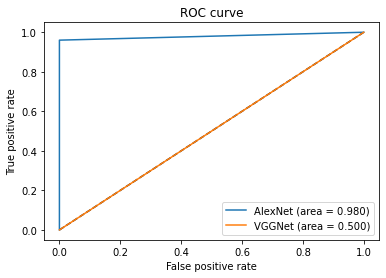

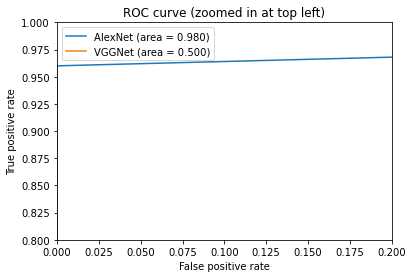

In [16]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt
########################################## Alexnet ##########################################
Alex_y_pred = np.array( [ np.argmax(model_A.predict(X_test[i].reshape(1, 227, 227, 1))) for i in range(len(y_test))] )
fpr_Alex, tpr_Alex, thresholds_keras = roc_curve(y_test, Alex_y_pred)
auc_Alex = auc(fpr_Alex, tpr_Alex)

########################################### VGG16 ###########################################
VGG_y_pred = np.array( [ np.argmax(model_V.predict(XX_test[i].reshape(1, 224, 224, 1))) for i in range(len(y_test))] )
fpr_VGG, tpr_VGG, thresholds_keras = roc_curve(y_test, VGG_y_pred)
auc_VGG = auc(fpr_VGG, tpr_VGG)






plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Alex, tpr_Alex, label='AlexNet (area = {:.3f})'.format(auc_Alex))
plt.plot(fpr_VGG, tpr_VGG, label='VGGNet (area = {:.3f})'.format(auc_VGG))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
# Zoom in view of the upper left corner.
plt.figure(2)
plt.xlim(0, 0.2)
plt.ylim(0.8, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_Alex, tpr_Alex, label='AlexNet (area = {:.3f})'.format(auc_Alex))
plt.plot(fpr_VGG, tpr_VGG, label='VGGNet (area = {:.3f})'.format(auc_VGG))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()